Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Импорт файла с данными для сравнения:

In [2]:
exp = pd.read_csv('EngineSem.ind', encoding='latin-1', header=None, skiprows = 19, delimiter='\s+')
exp.columns = ['Fi', 'Pc', 'Tc', 'Vc', 'Alf_w', 'P_1ring', 'G_bb', 'P_pist', 'x']
exp.head(5)

,Fi,Pc,Tc,Vc,Alf_w,P_1ring,G_bb,P_pist,x
0,180.0,1.93,346.4,0.001056,351.2,1.2636,0.000190,0.000,2.000000e+25
1,181.0,1.93,346.5,0.001055,351.3,1.2637,0.000190,0.007,2.000000e+25
2,182.0,1.93,346.6,0.001055,351.3,1.2639,0.000190,0.027,2.000000e+25
3,183.0,1.93,346.7,0.001055,351.4,1.2641,0.000191,0.062,2.000000e+25
4,184.0,1.93,346.8,0.001055,351.5,1.2644,0.000191,0.109,2.000000e+25


# Исходные данные по двигателю

### Геометрические параметры двигателя

In [3]:
D=0.102          # диаметр цилиндра, м
S=0.122          # ход поршня, м
n_mex=0.82956    # механический КПД
n=2400           # частота вращения, об/мин
icyl=6           # кол-во цилиндров
eps=18           # степень сжатия
lamb=0.264       # R/L
lo = 495.2       # стехиометрическое количество воздуха
alpha = 2.0      # коэффициент избытка воздуха

### Граничные и начальные условия

In [4]:
Tk=352            # Температура за компрессором, K
Pk=2.53*1E5       # Давление за компрессором, Па
Tog=862           # Температура ОГ, K
Pog=1.78*1E5      # Давление ОГ, Па

### Молярные массы веществ:

In [5]:
ml_sp = {'N2':  0.028,
         'O2':  0.032,
         'CO2': 0.044,
         'H2O': 0.018}

### Газораспределение и впрыскивание топлива

In [6]:
Fi_ovik=360-64    # Угол открытия выпускного клапана
Fi_zvik=540+18    # Угол закрытия выпускного клапапа
Fi_ovk=540-10     # Угол открытия впускного клапана
Fi_zvk=42         # Угол закрытия впускного клапана
muf_int=0.0027    # Максимальное проходное сечения впускного клапана
muf_exh=0.0027    # Максимальное проходное сечения выпускного клапана
Fi_ovt=0          # Угол опережения впрыскивания топлива

### Прочие константы

In [7]:
Rm=8.314          # Универсальная газовая постоянная
dFi=np.pi/180     # Приращение угла поворота КВ
N=900             # Статическое количество элементов в массивах

# Функции

### Объем КС как функция угла поворота коленчатого вала:
$$ V(\phi) = V_c + V_h -\frac{\pi D^2} 4 \frac{S} 2 ((1 - cos (\phi))-\frac{\lambda} 4 (1 -cos(2\phi)))$$

In [8]:
## Вписать функцию для расчета текущего объема в цилиндре двигателя
def vol(deg):
    Ap = np.pi * D ** 2 / 4
    Vh = Ap * S
    Vc = Vh / (eps - 1)
    V = Vc + Vh - Ap * S / 2 * (1 - np.cos(np.deg2rad(deg)) - lamb / 4 * (1 - np.cos(2 * np.deg2rad(deg))))
    return V

### Термодинамическая работа
$$ \frac{dL} {d\phi} = -p\frac{dV}{d\phi} $$

In [9]:
## Вписать функцию для расчета термодинамической работы
def rab(p, deg):
    rab_deg = p * (vol(deg + 1) / dFi - vol(deg) / dFi)
    return rab_deg

### Теплообмен с окружающими деталями КС:
$$ \frac{dQ_w} {d\phi} = \qquad \sum_{i=1}^3 \alpha_w(T-T_w^i)F_i \frac{dt}{d\omega} $$
Площадь крышки цилиндра:
$$ F_k = \frac{\pi D^2} 4 $$
Площадь поршня:
$$ F_p = 1.4 F_k $$
Площадь гильзы:
$$ F_{cyl}(\phi) = {\pi D}(\delta + S_p(\phi)) $$
Коэффициент теплоотдачи по формуле Г. Эйхельберга:
$$ \alpha_w(\phi) = 77.9 \cdot 10^{-4} C_m^{\frac 1 3} \sqrt{PT} $$

In [10]:
## Вписать функцию для расчета теплообмена со стенками КС
def heat_transfer(T, P, deg):
    Tp = 325 + 273.15
    Tk = 300 + 273.15
    Tc = 200 + 273.15
    delta = 1 * 10**(-3)
    Cm = (S * n) / 30
    #print(P)
    alpha = 77.9 * 10**(-4) * Cm**(1 / 3) * (P * T)**(1 / 2)
    Sphi = S / 2 * (1 - np.cos(np.deg2rad(deg)) - lamb / 4 * (1 - np.cos(np.deg2rad(2 * deg))))
    Qwc = -alpha * (T - Tc) * np.pi * D * (delta + Sphi) * 30 / np.pi / n
    Qwk = -alpha * (T - Tk) * np.pi * D * D / 4 * 30 / np.pi / n
    Qwp = -alpha * (T - Tp) * 1.4 * np.pi * D * D / 4 * 30 / np.pi / n
    
    Q = Qwc + Qwp + Qwk
    return Q

### Определение теплоемкости смеси газов в КС:


$$ C_v(M, T) = \qquad \sum_{i=1}^4 v_i C_v^i $$  где $v_i =   {M_i} / {M_{mixture}} $ 
$$ C_v^i (T) = \qquad \sum_{i=0}^6 A_i\left({{\frac {T-273.15} {1000}}}\right)^i $$

Таблица 1 – Коэффициенты для аппроксимации изохорной теплоемкости. газовая постоянная газов (Дж/кг/К)|
| Газ | С0       | С1      | С2       | С3       | С4       | С5      | С6      | Ri      |   |
|-----|----------|---------|----------|----------|----------|---------|---------|---------|---|
| H2  | 10077.23 | 1805.88 | -4894.86 | 6962.86  | -4546.27 | 1417.52 | -170.80 | 2124.3  |   |
| O2  | 654.56   | 68.44   | 264.35   | - 393.57 | 246.48   | -73.33  | 8.47    | 259.8   |   |
| N2  | 739.29   | -22.47  | 227.21   | - 185.89 | 70.01    | -12.38  | 0.77    | 296.8   |   |
| H2O | 1397.28  | 116.90  | 349.69   | - 269.54 | 112.47   | -27.73  | 3.05    | 461.6   |   |
| CO  | 2.53     | -27.36  | 118.96   | - 259.99 | 270.41   | -14.11  | 743.45  | 296.8   |   |
| CO2 | 623.42   | 642.051 | -894.27  | 1184.18  | -917.66  | 348.92  | -50.60  | 188.9   |   |0|188.9|




In [20]:
## Вписать функцию для расчета теплоемкости смеси газов
O2_lt = [654.56, 68.44, 264.35, -393.57, 246.48, -73.33, 8.47, 259.8] #O2
N2_lt = [739.29, -22.47, 227.21, -185.89, 70.01, -12.38, 0.77, 296.8] #N2
H20_lt = [1397.28, 116.90, 349.69, -269.54, 112.47, -27.73, 3.05, 461.6] #H20
CO2_lt = [623.42, 642.051, -894.27, 1184.18, -917.66, 348.92, -50.60, 188.9] #CO2

def Cv(T, M_N2, M_O2, M_CO2,  M_H2O, M_Mixture):
    
    O2_l = np.sum([O2_lt[i] * ml_sp['O2'] * ((T - 273.15) / 1000) ** i for i in range(6)])
    N2_l = np.sum([N2_lt[i]  * ml_sp['N2'] * ((T - 273.15) / 1000) ** i for i in range(6)])
    H20_l = np.sum([H20_lt[i] * ml_sp['H2O'] * ((T - 273.15) / 1000) ** i for i in range(6)])
    CO2_l = np.sum([CO2_lt[i] * ml_sp['CO2'] * ((T - 273.15) / 1000) ** i for i in range(6)])
    
    result = O2_l * (M_O2 / M_Mixture) + N2_l * (M_N2 / M_Mixture) + H20_l * (M_H2O / M_Mixture) + CO2_l * (M_H2O / M_Mixture)
    return result


# Основная программа

### Объявление массивов

In [12]:
P = np.zeros((N+1, 1)) # давление, Па
T = np.zeros((N+1, 1))             # температура, K
# кол-во вещества, моль
M = {
    'N2':  np.zeros((N+1, 1)),
    'O2':  np.zeros((N+1, 1)),
    'CO2': np.zeros((N+1, 1)),
    'H2O': np.zeros((N+1, 1)),
    'Mixture': np.zeros((N+1, 1))
    }

### Начальные данные для расчета рабочего процесса

Возьмем значения в цилиндре двигателя на момент его закрытия, равными "экспериментальным"

In [13]:
P[Fi_zvk] = exp['Pc'][Fi_zvk]*1e5
T[Fi_zvk] = exp['Tc'][Fi_zvk]

Состав смеси газов на момент закрытия впускного клапана = воздух

In [14]:
M['Mixture'][Fi_zvk] = P[Fi_zvk] * vol(Fi_zvk) / T[Fi_zvk] / Rm
M['N2'][Fi_zvk] = 0.79 * M['Mixture'][Fi_zvk]
M['O2'][Fi_zvk] = 0.21 * M['Mixture'][Fi_zvk]
M['CO2'][Fi_zvk] = 0
M['H2O'][Fi_zvk] = 0

По коэффициенту избытка воздуха можно определить соответствующую цикловую подачу

In [15]:
## оценить величину цикловой подачи

### Расчет процесса сжатия

Для процесса сжатия алгебраическая система уравнений для закрытой термодинамической системы решается последовательно в цикле:
$$ \Delta T = \frac{\dfrac{dL}{d\phi}\bigg|_{Fi} + \dfrac{dQ_w} {d\phi} \bigg|_{Fi}} {C_v(Fi)\cdot M_{mixture}(Fi)} $$
$$ T_{Fi+1} = T_{Fi} + \Delta Fi \cdot \Delta T  $$
$$ M {[NO2]}_{Fi+1} = M {[NO2]}_{Fi} + 0 $$
$$ M {[CO2]}|_{Fi+1} = M {[CO2]}_{Fi} + 0  $$
$$ M {[N2]}_{Fi+1} = M {[N2]}_{Fi} + 0 $$
$$ M {[O2]}_{Fi+1} = M {[O2]}_{Fi} + 0 $$
$$ M {[Mixture]}_{Fi+1} = \qquad \sum_{i=1}^4 M^i_{Fi+1} $$
$$ p_{Fi+1} = \frac {M {[Mixture]}_{Fi+1} T_{Fi+1} R_m} {V_{Fi+1}}  $$

Пусть пока теплоемкость будет 23, потом исправим

In [16]:
## цикл для определения результатов на каждом следующем шаге расчета до начала процесса сгорания (пока можно на все 720 градусов сделать)
for i in range(Fi_zvk, 721):
    cv = Cv(T[i], M['N2'][i], M['O2'][i], M['CO2'][i], M['H2O'][i], M['Mixture'][i])
    #print(cv)
    dT = (-rab(P[i], i) + heat_transfer(T[i], P[i], i)) / cv / M['Mixture'][i]
    T[i + 1] = T[i] + dFi * dT
    M['N2'][i + 1] = M['N2'][Fi_zvk] + 0
    M['CO2'][i + 1] = M['CO2'][Fi_zvk] + 0
    M['N2'][i + 1] = M['N2'][Fi_zvk] + 0
    M['O2'][i + 1] = M['O2'][Fi_zvk] + 0
    M['Mixture'][i + 1] = M['Mixture'][i]
    P[i + 1] = M['Mixture'][i + 1] * T[i + 1] * Rm / vol(i + 1)

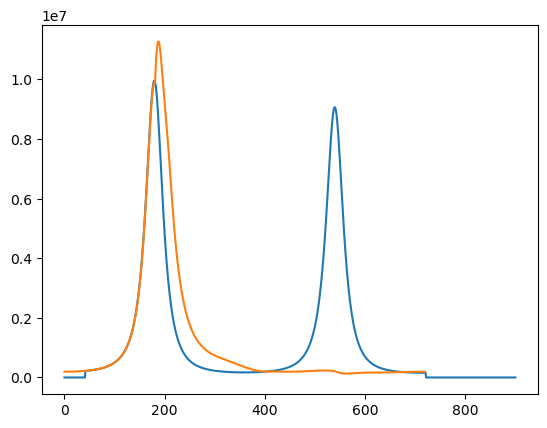

In [17]:
plt.plot(P)
plt.plot(exp['Pc'] * 1E5)

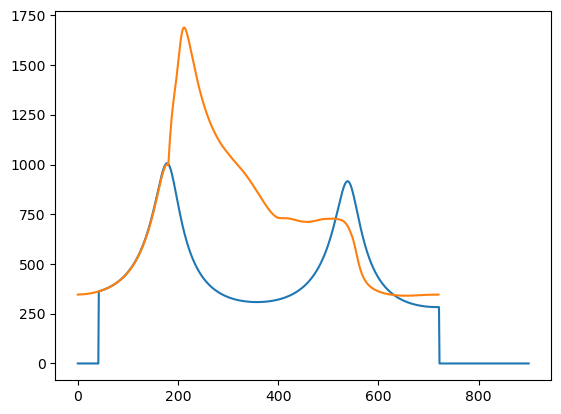

In [18]:
plt.plot(T)
plt.plot(exp['Tc'])

# Отображение результатов 

Графики давления и температуры в КС

In [19]:
## вписать код для отобращения результатов расчета - Давление и Температура (сравнение с данными исходного файла)